## This assignment is about computing the essential matrix F associated with N correspondences from the "house" data shown in class.

## Instructions
- Please zip this notebook with other files, and rename the folder as netID-HW3.zip 
- Before sending your notebook, please make sure your code can be run by restarting your jupyter kernel and relaunching all the cells.
- Make sure your answer to the questions are visible.
- Deadline: 14th April, 2023

In [180]:
import os
import matplotlib.pyplot as plt
import numpy as np

**0)** Define your path to the folder containing the data points:

In [181]:
path = 'data'

You can directly use the following functions, especially `read_data` to load points in two chosen views, and `plot_edges` to visualize points from one view and the edges connecting them.

In [182]:
def file_to_array(file_path):
    """
    Params:
    -------
    file_path: str
        path to file with image points.
    
    Returns:
    --------
    pts: np.array
        array of size (N, 2). N points of coordinates (x, y).
    """
    with open(file_path) as f:
        views = dict()
        pt2d = f.readlines()
        for line in pt2d:
            if len(line.split(" ")) == 3:
                pt_id = line.split(" ")[0]
                views[pt_id] = (float(line.split(" ")[1]), float(line.split(" ")[2][:-1]))
    pts = np.zeros((len(views), 2))
    for i in range(len(pts)):
        pts[i] = views[str(i+1)] 

    return pts

def read_data(data_path, idx1, idx2):
    """
    Params:
    -------
    data_path: str
        path to folder where 'pt_2D{}' are stored.
    idx1: int
        idx of first view.
    idx2: int 
        idx of second view.
    
    
    Returns:
    --------
    pts1, pts2, edges_processed
    pts1: np.array
        array of size (N, 2). N points of coordinates (x, y) in view idx1.
    pts2: np.array
        array of size (N, 2). N points of coordinates (x, y) in view idx2.
    edges_processed: list
        list of tuples. (i, j) is in edges_processed if there is an edge between 
        point of idx i and point of idx j.
    """
    pt1_2D_path = os.path.join(data_path, 'pt_2D{}'.format(idx1))
    pt2_2D_path = os.path.join(data_path, 'pt_2D{}'.format(idx2))
    
    pts1 = file_to_array(file_path=pt1_2D_path)
    pts2 = file_to_array(file_path=pt2_2D_path)
    
    # Load edges
    edges_path = os.path.join(path, 'edges')

    with open(edges_path) as f:
        edges_raw = f.readlines()
        
    edges_processed = []
    for edge in edges_raw:
        if len(edge.split(" ")) == 2:
            edges_processed.append((int(edge.split(" ")[0]), int(edge.split(" ")[1][:-1])))
    min_points = np.minimum(len(pts1), len(pts2))
    
    return pts1[:min_points], pts2[:min_points], edges_processed

def plot_edges(pts, edges):
    """
    Params:
    -------
    pts: np.array
        array of size (N, 2). N points of coordinates (x, y).
    edges: list
        list of tuples. (i, j) is in edges if there is an edge between points of indices i and j.
    
    Plots edges.
    """
    
    plt.figure()
    for i, edge in enumerate(edges):
        # print(i)
        coord1 = pts[edges[i][0] - 1]
        coord2 = pts[edges[i][1] - 1]
        x = [coord1[0], coord2[0]]
        y = [coord1[1], coord2[1]]
        plt.plot(x, y, 'ro-')

For this exercise, let us use views 2 and 5 of the house:

**1)** Load the data corresponding to images 2 and 5 using `read_data`.

In [183]:
pts2, pts5, edge = read_data(path, 2, 5)

**2)** Use `plot_edges` to show show the edges overlayed over images 2 and 5.

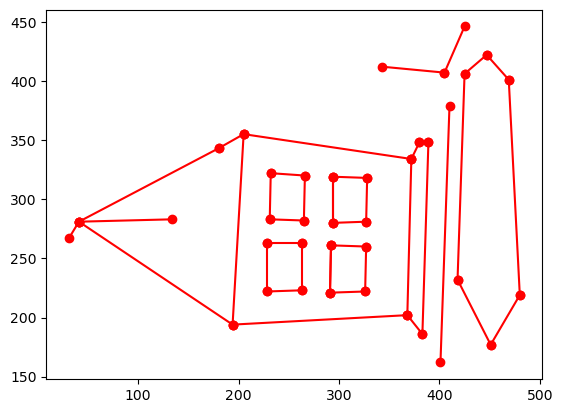

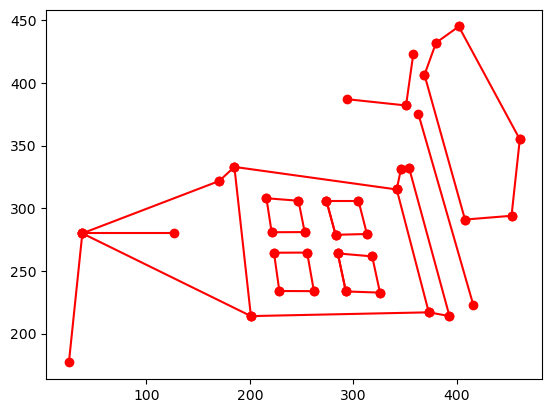

In [184]:
plot_edges(pts2, edge)
plot_edges(pts5, edge)

**3.a)** Compute the fundamental matrix F directly from these points using
homogeneous linear least-squares.

\begin{align*}
p &= k[r t]\\
p = \text{camera}, k &= \text{intrinsics}, r = \text{rotation}, t = \text{translation}, [r t] \text{ is } 3 \times 4 \text{ matrix}\\
k &= \begin{pmatrix} f_x & s & c_x\\ 0 & f_y & c_y\\ 0 & 0 & 1 \end{pmatrix}\\
(f_x, f_y) = \text{focal length}, (c_x, c_y) &= \text{optical center}, s = \text{skew}\\
w\begin{pmatrix} x\\ y\\ z\end{pmatrix} &= p\begin{pmatrix}x\\ y\\ z\\ 1\end{pmatrix}\\
\begin{pmatrix} x\\ y\\ z\end{pmatrix} &= \begin{pmatrix}p_1 & p_2 & p_3 & p_4\\ p_5 & p_6 & p_7 & p_8\\ p_9 & p_{10} & p_{11} & p_{12}\end{pmatrix}\begin{pmatrix}x\\ y\\ z\\ 1\end{pmatrix}\\
w = \text{scale factor}, (x, y, 1) &= \text{image points}, (x, y, z, 1) = \text{world points}\\
f &= \text{fundamental matrix}\\
{x_i'} ^ t f x_i &= 0\\
\begin{pmatrix}x_i' & y_i' & 1\end{pmatrix}
\begin{pmatrix}f_{11} & f_{12} & f_{13}\\ f_{21} & f_{22} & f_{23}\\ f_{31} & f_{32} & f_{33}\end{pmatrix}\begin{pmatrix}x_i\\ y_i\\ 1\end{pmatrix} &= 0
\end{align*}

`compute_fundamental_matrix()` uses the eight point algorithm to estimate the fundamental matrix with the epipolar constraint ${x_i'} ^ t f x_i = 0$. the eight point algorithm assumes that the dataset contains at least 8 pairs of corresponding points from two images

In [185]:
def compute_fundamental_matrix(pts1, pts2):
    n = pts1.shape[0]
    a = np.zeros((n, 9))
    for i in range(n):
        x1, y1 = pts1[i, 0], pts1[i, 1]
        x2, y2 = pts2[i, 0], pts2[i, 1]
        a[i] = [x1 * x2, y1 * x2, x2, x1 * y2, y1 * y2, y2, x1, y1, 1]
    u, s, v = np.linalg.svd(a)
    f = v[-1, :].reshape(3, 3)
    u, s, v = np.linalg.svd(f)
    s[-1] = 0
    f = u @ np.diag(s) @ v
    return f

f = compute_fundamental_matrix(pts2, pts5)

**3.b)** Report the mean distance between the points and the corresponding epipolar lines.

camera projection matrices are
\begin{align*}
M &= K[I\;0]\\
M' &= K'[R ^ T -R ^ T T] 
\end{align*}

define $p_c = K ^ {-1}p$ and $p_c' = {K'} ^ {-1}p'$ to be the projections of $p$ to the corresponding camera images

\begin{align*}
p_c ^ T[T]Rp_c' &= 0\\
p ^ T K ^ {-T}[T]R{K'} ^ {-1}p' &= 0
\end{align*}

$F = K ^ {-T}[T]R{K'} ^ {-1}$ is fundamental matrix

In [186]:
def compute_distance(pts1, pts2, f):
    epipolar_line = f @ pts1
    return abs(pts2 @ epipolar_line) / np.sqrt(epipolar_line[0] ** 2 + epipolar_line[1] ** 2)

distances = [compute_distance(np.append(pts2[i], 1), np.append(pts5[i], 1), f) for i in range(pts2.shape[0])]
mean_distance = np.mean(distances)
print('mean distance:', mean_distance)

mean distance: 98.82981494664749


**4.a)** Write a function, that given F, draws the epipolar lines associated
with the points from pts1, and overlays them on the points from
pts2, drawn using plot_edges.

compute the epipolar lines $l' = F ^ T p$ and $l = Fp'$ from the fundamental matrix

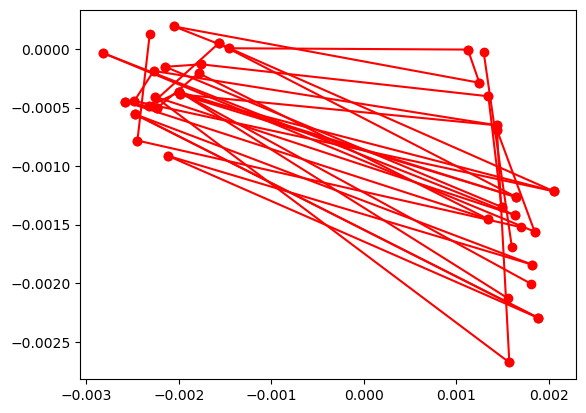

In [187]:
def plot_epipolar_lines(f, pts1, pts2, edge):
    n = pts1.shape[0]
    a = []
    for i in range(n):
        p1 = pts1.T[:, i]
        p2 = pts2.T[:, i]
        p1 = np.append(p1, 1)
        p2 = np.append(p2, 1)
        coeff = f.T @ p1
        a.append(coeff)
        coeff = f @ p2
        a.append(coeff)
    plot_edges(a, edge)

plot_epipolar_lines(f, pts2, pts5, edge)

**4.b)** Do the same switching the roles of pts1 and pts2.

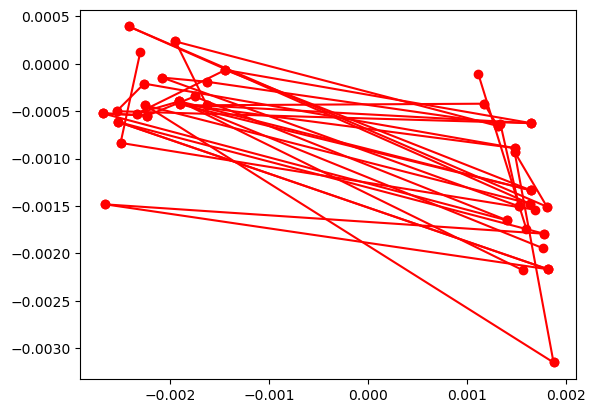

In [188]:
def plot_epipolar_lines2(f, pts1, pts2, edge):
    n = pts1.shape[0]
    a = []
    for i in range(n):
        p1 = pts1.T[:, i]
        p2 = pts2.T[:, i]
        p1 = np.append(p1, 1)
        p2 = np.append(p2, 1)
        coeff = f.T @ p2
        a.append(coeff)
        coeff = f @ p1
        a.append(coeff)
    plot_edges(a, edge)

plot_epipolar_lines2(f, pts2, pts5, edge)

**5)** Do the same thing using the Harltley normalization:

**5.a)** Compute the matrices $T_1$ and $T_2$.

the standard least squares approach in the eight point algorithm can result in a high distance between a point $p_i$ and the corresponding epipolar line $l_i = Fp'$. to reduce the error, use a normalized version of the eight point algorithm. first normalize points by computing the centroids $c_1, c_2$, the scaling factor, and normalization matrices so the mean square distance of the transformed image points and the origin is 2 pixels, and translate the centroid and scale the transformation matrices by factor $\frac{2}{mean\;distance}$ for each image 

In [189]:
def compute_fundamental_matrix_normalize(pts1, pts2):
    n = pts1.shape[0]
    c1 = np.mean(pts1, axis = 0)
    c2 = np.mean(pts2, axis = 0)
    s1 = np.sqrt(2 / np.mean(np.sum((pts1 - c1) ** 2, axis = 1)))
    s2 = np.sqrt(2 / np.mean(np.sum((pts2 - c2) ** 2, axis = 1)))
    t1 = np.array([[s1, 0, -s1 * c1[0]], [0, s1, -s1 * c1[1]], [0, 0, 1]])
    t2 = np.array([[s2, 0, -s2 * c2[0]], [0, s2, -s2 * c2[1]], [0, 0, 1]])
    points1, points2 = [], []
    for i in range(n):
        points1.append(np.append(pts1[i], 1))
        points2.append(np.append(pts2[i], 1))
    pts1_n = t1 @ np.array(points1).T
    pts2_n = t2 @ np.array(points2).T
    f_n = compute_fundamental_matrix(pts1_n.T, pts2_n.T)
    print('t1\n', t1)
    print('t2\n', t2)
    return t2.T @ f_n @ t1

**5.b)** Compute the new matrice $F'$

In [190]:
f_prime = compute_fundamental_matrix_normalize(pts2, pts5)

t1
 [[ 0.01078886  0.         -3.35192893]
 [ 0.          0.01078886 -3.16397561]
 [ 0.          0.          1.        ]]
t2
 [[ 0.01193316  0.         -3.48962112]
 [ 0.          0.01193316 -3.5684994 ]
 [ 0.          0.          1.        ]]


**5.c)** Report the mean distance between the points and the corresponding epipolar lines.

In [191]:
distances = [compute_distance(np.append(pts2[i], 1), np.append(pts5[i], 1), f_prime) for i in range(pts2.shape[0])]
mean_distance = np.mean(distances)
print('mean distance:', mean_distance)

mean distance: 0.8996831565649506


**5.d)** Draw the epipolar lines associated with the points from `pts2` and overlay them on the points from
`pts1`, drawn using `plot_edges`.

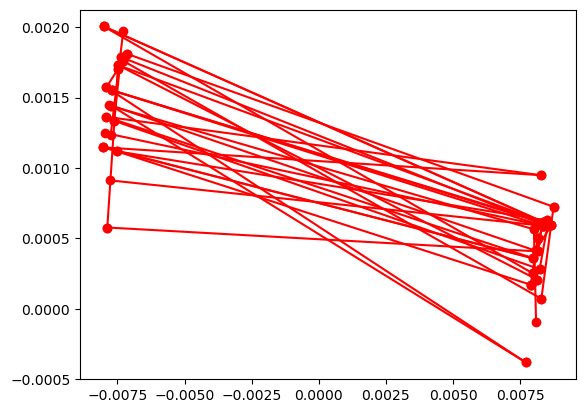

In [192]:
plot_epipolar_lines(f_prime, pts2, pts5, edge)

**5.e)** Do the same switching the roles of `pts1` and `pts2`.

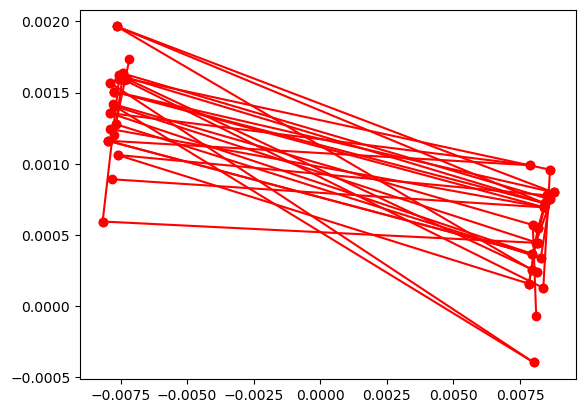

In [193]:
plot_epipolar_lines2(f_prime, pts2, pts5, edge)